# Character level language model - Dinosaurus land

Welcome to Dinosaurus Island! 65 million years ago, dinosaurs existed, and in this assignment they are back. You are in charge of a special task. Leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and your job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go beserk, so choose wisely! 

<table>
<td>
<img src="images/dino.jpg" style="width:250;height:300px;">

</td>

</table>

Luckily you have learned some deep learning and you will use it to save the day. Your assistant has collected a list of all the dinosaur names they could find, and compiled them into this [dataset](dinos.txt). (Feel free to take a look by clicking the previous link.) To create new dinosaur names, you will build a character level language model to generate new names. Your algorithm will learn the different name patterns, and randomly generate new names. Hopefully this algorithm will keep you and your team safe from the dinosaurs' wrath! 

By completing this assignment you will learn:

- How to store text data for processing using an RNN 
- How to synthesize data, by sampling predictions at each time step and passing it to the next RNN-cell unit
- How to build a character-level text generation recurrent neural network


In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pdb
from torch.utils.data import Dataset, DataLoader

# torch.set_printoptions(linewidth=200)


In [3]:
# hidden_size = 100
class DinosDataset(Dataset):
    def __init__(self):
        super().__init__()
        with open('G:\pythonalgos\RNNhw\dinos.txt') as f:
            content = f.read().lower()
            self.vocab = sorted(set(content))
            self.vocab_size = len(self.vocab)
            self.lines = content.splitlines()

        self.ch_to_idx = {}
        self.idx_to_ch = {}

        self.ch_to_idx['\n'] = 0
        self.idx_to_ch[0] = '\n'

        for i in range(26):
            curch = chr(i + 97)
            self.ch_to_idx[curch] = i + 1
            self.idx_to_ch[i + 1] = curch


    def __getitem__(self, index):
        line = self.lines[index]
        x_str = ' ' + line  # add a space at the beginning, which indicates a vector of zeros.
        y_str = line + '\n'
        x = torch.zeros([len(x_str), self.vocab_size], dtype=torch.float)
        y = torch.empty(len(x_str), dtype=torch.long)

        y[0] = self.ch_to_idx[y_str[0]]
        #we start from the second character because the first character of x was nothing(vector of zeros).
        for i, (x_ch, y_ch) in enumerate(zip(x_str[1:], y_str[1:]), 1):
            x[i][self.ch_to_idx[x_ch]] = 1
            y[i] = self.ch_to_idx[y_ch]

        return x, y

    def __len__(self):
        return len(self.lines)


In [4]:
# do some test on the dataset
dset_test = DinosDataset()
print(dset_test.ch_to_idx)
print(dset_test.lines[1016])
print(len(dset_test))
print(dset_test.vocab_size)
dset_test[1016]


{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
pamparaptor
1536
27


(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0

In [5]:
hidden_size = 40


class RNN(nn.Module):
    def __init__(self, inputsize, hidsize):
        super().__init__()

        self.rnn = nn.RNNCell(
            input_size=inputsize,
            hidden_size=hidsize,
            bias=True
        )

        # output layer !!!!! important !!!
        self.fc = nn.Linear(hidsize, inputsize)

    def forward(self, x, h_state):
        h_state = self.rnn(x, h_state)
        y = self.fc(h_state)
        return h_state, y


In [6]:
# do some test on random choice API
prob = np.array([0.1, 0, 0.4, 0.5])

for i in range(20):
    smplindx = np.random.choice(range(len(prob)), p=prob.ravel())
    print(smplindx, end=",")
    
tensortest=torch.Tensor([1,2,3]).float()
np.array(tensortest)

3,3,3,2,2,3,2,3,3,2,0,3,3,3,2,2,2,3,3,3,

array([1., 2., 3.], dtype=float32)

In [7]:
def sample(model: RNN):
    # my comment: notify in eval mode now
    model.eval()

    word_size = 0
    newline_idx = trn_ds.ch_to_idx['\n']
    indices = []
    pred_char_idx = -1

    # Step 1: initialize first input and hidden state ---all zero---
    h_prev = torch.zeros([1, hidden_size], dtype=torch.float)
    x = torch.zeros([1, trn_ds.vocab_size], dtype=torch.float)

    # my comment: with torch.no_grad() is to stop autograd to speed up a bit
    with torch.no_grad():
        while pred_char_idx != newline_idx and word_size != 50:
            # Step 2: Forward propagate x using the equations (1), (2) and (3)
            h_prev,oval = model.forward(x, h_prev)

            #np.random.seed(np.random.randint(1, 5000))
            # Step 3: Sample the index of a character within the vocabulary from the probability distribution
            # print(x[0, 0].sum())
            idx = np.random.choice(range(oval.size(1)), p=np.array(F.softmax(oval[0])).ravel())
            indices.append(idx)
            #print('choice:', idx, 'out:', h_prev[0])

            # Step 4: Overwrite the input character as the one corresponding to the sampled index.            
            x = torch.zeros([1, trn_ds.vocab_size], dtype=torch.float)
            x[0, idx] = 1
            pred_char_idx = idx
            word_size += 1
        if word_size == 50:
            indices.append(newline_idx)
    return indices

def print_sample(sample_idxs):
    print(trn_ds.idx_to_ch[sample_idxs[0]].upper(), end='')
    [print(trn_ds.idx_to_ch[x], end='') for x in sample_idxs[1:]]


In [8]:
def train_one_epoch(model: RNN, loss_fn, optimizer):
    loss_arr=[]
    # Go through the training examples one at a time
    for line_num, (x, y) in enumerate(trn_dl):
        # my comment: it should means switching to training mode
        model.train()

        loss = torch.zeros(1)
        optimizer.zero_grad()

        # Initialize parameters
        h_prev = torch.zeros([1, hidden_size], dtype=torch.float, requires_grad=True)
        
        for i in range(x.shape[1]):
            # Forward propagate through the RNN to compute the loss
            h_prev, outval = model.forward(x[:, i, :], h_prev)
            y_correct = y[:, i]
            #print(loss_fn(outval, y_correct))
            loss += loss_fn(outval, y_correct)

        # Backpropagate through time
        # loss /= x.shape[1]
        loss.backward()

        # Clip your gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        # Update parameters
        optimizer.step()

        # Every 100 steps of stochastic gradient descent, 
        # print one sampled name to see how the algorithm is doing
        if (line_num + 1) % 100 == 0:
            print_sample(sample(model))
            #print('loss=', loss.data.numpy()[0])
        loss_arr.append(loss.data.numpy()[0])
    return loss_arr

In [9]:
import matplotlib.pyplot as plt

trn_ds = DinosDataset()
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True)

def train(trn_ds, trn_dl, epochs=1):
    model = RNN(trn_ds.vocab_size,hidden_size)
    
    # Use cross entropy loss
    loss_fn = nn.CrossEntropyLoss()
    
    # Use Adam
    learning_rate = 0.1
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for e in range(1, epochs + 1):
        print(f'{"-" * 20} Epoch {e} {"-" * 20}')
        curlossarr=train_one_epoch(model, loss_fn, optimizer)
        #print(curlossarr)
        x_axis = np.arange(len(curlossarr))
        plt.plot(x_axis, curlossarr, label='train loss')
        plt.legend()
        plt.show()

-------------------- Epoch 1 --------------------


g:\pythonalgos\venv\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Uoa


Osinidsaurus


Asaurus


Aliasaurus


Coshtchus


Inhixhsoustaeceood


Tanytan


Manertisachusaurus


Wabap


Tichogglsacosaurur


Gukoladtossus


Alabonigosaoran


Stomastirus


Arachisaurus


Leosaurus


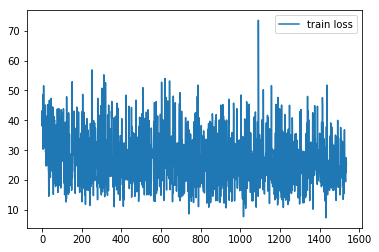

-------------------- Epoch 2 --------------------


Mankmakisaurus


Atitosaurus


Tungysaurus


Kenasaurus


Kenbinstorisaurus


Olamendicratoos


Nubnosaurus


Goraasaurusjurusaurus


Ptavhens


Tonopsis


Elotapenosaurus


Bixyyriisaurus


Lozhusaurus


Awdhesaurus


Mmidomce


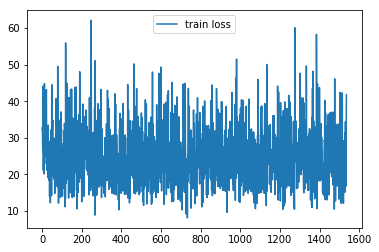

-------------------- Epoch 3 --------------------


Hanlodoxus


Fitnyposaurus


Antay


Chogoolosaurus


Tazalontiua


Aurakelasaurus


Ggonyosaurus


Sangusaurus


Alalisochus


Ushuros


Rorhidosaurus


Trabonopleron


Hynjydya


Coluyiasaurus


Yuuicanohusaurus


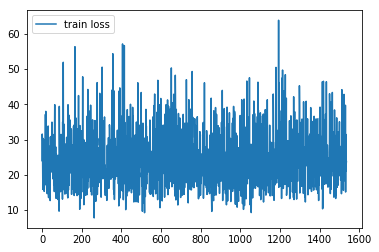

-------------------- Epoch 4 --------------------


Lxisaurus


Vocoraa


Secudrosaurus


Teuangitossus


Amoanosaurus


Selalesaurus


Agriylurus


Eovroperhadol


Enfacos


Monoosong


Shyrodia


Palkitotgosdususjinkasaurus


Tollaponatops


Lerosaurus


Ptoton


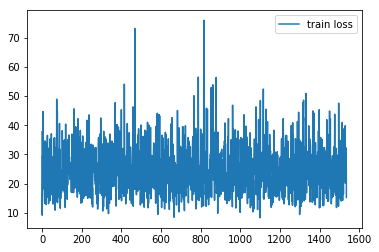

-------------------- Epoch 5 --------------------


Iabchesaurus


Liguscriatluthetatatus


Totoanenuhosaurus


Ganesaurus


Crontosaurus


Phatropnstrtirivasus


Phiagepiingosaurus


Orasaurus


Proinsaurus


Jotrovol


Gosanojsaurus


Ximbrerausaus


Jriphops


Sheymurasaurus


Tatandongosaurus


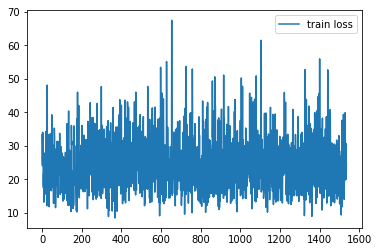

In [10]:
#Start training
train(trn_ds, trn_dl, epochs=5)
